# Time-series Forecasting as an introduction to Recurrent Neural Networks

In this class, we'll cover time-series forecasting. This family of algorithms can be used for a variety of prediction tasks, such as [predicting stock prices](https://arxiv.org/pdf/1911.13288.pdf) and [seizure prediction](https://www.sciencedirect.com/science/article/pii/S001048251830132X). We'll focus on the use of Recurrent Neural Networks in this context.

The data we'll use today is a set of EEG readings used to study seizures. You can find the data [here](https://physionet.org/content/chbmit/1.0.0/), and in the `data` directory there is a single patient recording `chb01_chb01_03.edf` which includes a seizure episode. We won't focus on seizure detection today but will instead try to predict neural activity.

These files are stored in the European Data Format, https://www.edfplus.info/. We'll use the python library `pyedflib` to read them.

In [1]:
# pip install pyedflib

In [2]:
import pyedflib
import torch
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os

In [3]:
file_name = os.path.join('data','chb01_chb01_03.edf')
f = pyedflib.EdfReader(file_name)

In [4]:
n = f.signals_in_file
labels = f.getSignalLabels()
print('%d different signals: %s' % (n, str(labels)))

23 different signals: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']


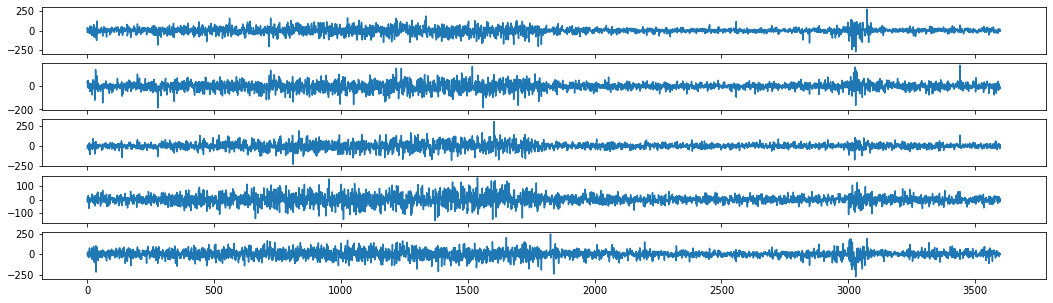

In [5]:
fig, axs = plt.subplots(5, sharex=True, figsize=(18,5))
for i in range(5):
    signal = f.readSignal(i)
    axs[i].plot(signal[::256])

As we can see, this single recording contains 23 different signals from different sensors placed. We'll focus at predicting a single signal. Our first data processing step is normalizing the data. This is beneficial for recurrent neural network training, but does require domain knowledge. In this case, we know the physical limits of the sensors, so we can use that to normalize the data between $[-1, 1]$.

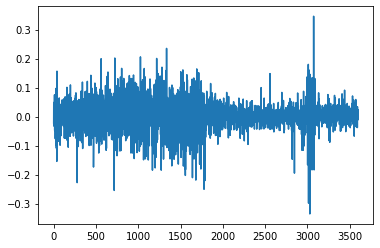

In [9]:
signal = f.readSignal(0)
signal = 2 * (signal - f.physical_min(0)) / (f.physical_max(0) - f.physical_min(0)) - 1.0
plt.plot(signal[::256])

Another preparation often done with timeseries data is to check if it is **stationary**, ie if the mean and variance change over time. To do this, we'll use the [Dickey-Fuller test](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test). This test can be very costly to compute, so we'll downsample the data. There are 256 samples per second in this data, so we'll take one sample each second.

In [8]:
import statsmodels.api as sm
p_value = sm.tsa.stattools.adfuller(signal[::256])[1]
p_value

9.655290037084316e-30

The small value means that the timeseries **is stationary**. This isn't a necessary condition for LSTMs, but it will help training. When the timeseries is not stationary (`p_value > 0.05`), it's normal to instead predict the **difference** between timesteps, ie $$y_t - y_{t-1}$$ which can be calculated in numpy using `diff` and in pandas with `shift`.

Finally, we split our data into training and test sets, perserving order:

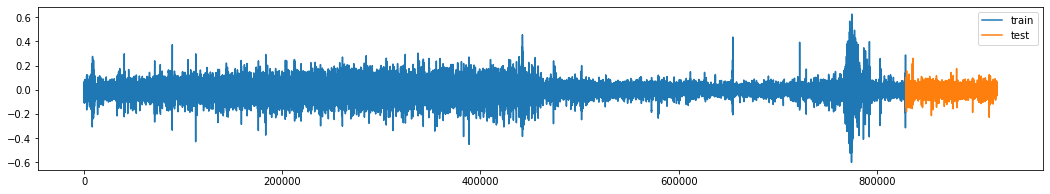

In [10]:
train_n = int(9 * len(signal) / 10)
train_x = list(range(train_n))
train_signal = signal[:train_n]
test_x = list(range(train_n, len(signal)))
test_signal = signal[train_n:]
plt.figure(figsize=(18,3))
plt.plot(train_x, train_signal, label='train')
plt.plot(test_x, test_signal, label='test')
plt.legend(loc='upper right');

The examples we'll be looking at today are
+ Univariate: we're using one signal to predict the future of that signal without considering other features. The opposite of this is multivariate, where multiple features are used in prediction (and multiple features can be simultaneously predicted)
+ 1-Step: we're predicting one step into the future, which can also be said as having a horizon of one sample. N-step or multi-step timeseries prediction is just an extension to this.

# Baselines

First we'll analyse the data and propose some simple baselines. We'll use **iterative prediction**, also known as walk-forward, to predict the next step at each timestep. The first baseline we'll use is called the naive baseline, which simply uses the previous value.

In [26]:
# walk-forward validation
history = np.append(train_signal, np.zeros(len(test_signal)))
predictions = np.zeros(len(test_signal))
for i in range(len(test_signal)):
    t = len(train_signal) + i
    # make prediction
    predictions[i] = history[t-3]
    # observation
    history[t] = test_signal[i]

In [27]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(predictions, test_signal))

0.019491212150264923

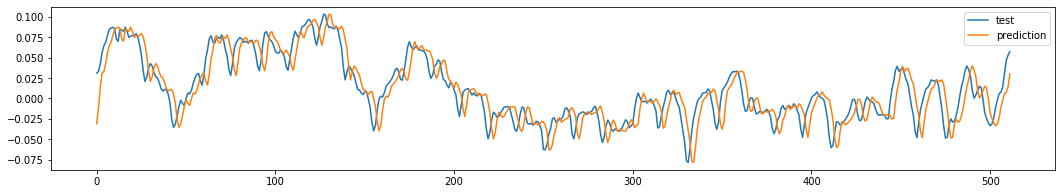

In [28]:
plt.figure(figsize=(18,3))
plt.plot(test_signal[:512], label='test')
plt.plot(predictions[:512], label='prediction')
plt.legend();

For a horizon of 1, the naive baseline is pretty good. Let's see if the historical data beyond one timestep can be useful. We'll start with a windowed approach, using the average of the past `W=5` timesteps as our prediction.

In [29]:
history = np.append(train_signal, np.zeros(len(test_signal)))
predictions = np.zeros(len(test_signal))
for i in range(len(test_signal)):
    t = len(train_signal) + i
    # make prediction
    predictions[i] = np.mean(history[t-53:t-3])
    # observation
    history[t] = test_signal[i]

0.029315246176187092


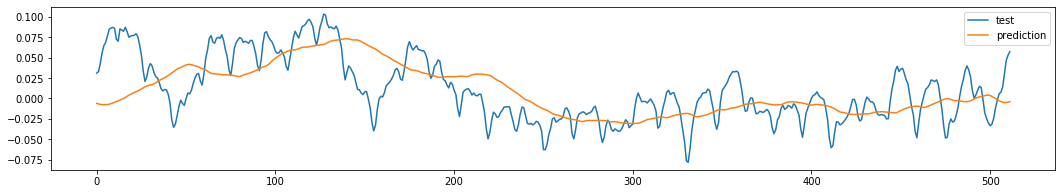

In [30]:
print(np.sqrt(mean_squared_error(predictions, test_signal)))
plt.figure(figsize=(18,3))
plt.plot(test_signal[:512], label='test')
plt.plot(predictions[:512], label='prediction')
plt.legend();

While this captures the general trend of some parts of the data, the naive baseline is still superior in terms of root mean squared error. Another approach is to exponentially decrease the dependency on past predictions, known as exponential smoothing. The rate by which we decrease past predictions is the parameter $\alpha$.

In [22]:
def exponential_smoothing(alpha):
    history = np.append(train_signal, np.zeros(len(test_signal)))
    predictions = np.zeros(len(test_signal))
    for i in range(len(test_signal)):
        t = len(train_signal) + i
        # make prediction
        if i == 0:
            predictions[i] = history[t-1]
        else:    
            predictions[i] = alpha * history[t-1] + (1 - alpha) * predictions[i-1]
        # observation
        history[t] = test_signal[i]
    return predictions

In [23]:
predictions_01 = exponential_smoothing(0.1)
print(np.sqrt(mean_squared_error(predictions_01, test_signal)))

0.02056131670801407


In [24]:
predictions_05 = exponential_smoothing(0.5)
np.sqrt(mean_squared_error(predictions_05, test_signal))

0.011937740167605865

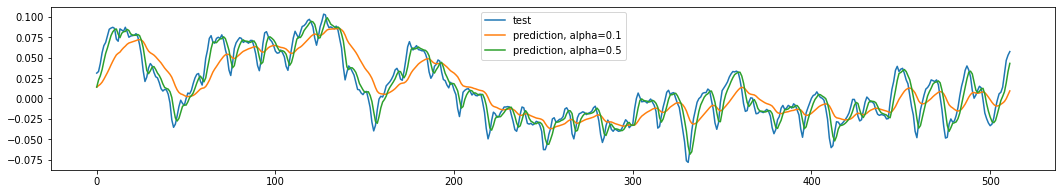

In [25]:
plt.figure(figsize=(18,3))
plt.plot(test_signal[:512], label='test')
plt.plot(predictions_01[:512], label='prediction, alpha=0.1')
plt.plot(predictions_05[:512], label='prediction, alpha=0.5')
plt.legend();

While lower alpha values help predict the general trend of our data, their RMSE is worse than using very short history. So for this EEG data, we're still struggling to make good use of the historical data to predict future data. Instead of a single parameter for history decay, we'll instead use a recurrent neural network to inform our reliance on memory for prediction, and optimize the network parameters using Stochastic Gradient Descent.

<div class="alert alert-success">
Exercise 1:
Apply these baselines to the `monthly-car-sales.csv` file, which records monthly car sales in Quebec, Canada between 1960 and 1968.

+ Is this data stationary?
+ What is a good alpha to use with this data?
+ This data is monthly; is there any naive baseline better than taking the previous day's value?
</div>

In [32]:
import pandas as pd
df = pd.read_csv('data/monthly-car-sales.csv')
df.head()

,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


In [53]:
df['Sales'].diff(1)

0         NaN
1      2178.0
2      3298.0
3      2369.0
4       192.0
        ...  
103   -1302.0
104   -2337.0
105    6957.0
106   -4162.0
107   -2603.0
Name: Sales, Length: 108, dtype: float64

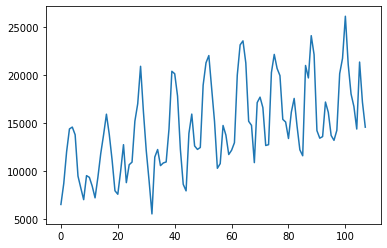

In [36]:
series = np.array(df['Sales'].array)
plt.plot(series);

In [38]:
import statsmodels.api as sm
p_value = sm.tsa.stattools.adfuller(series)[1]
p_value

0.6632691049832871

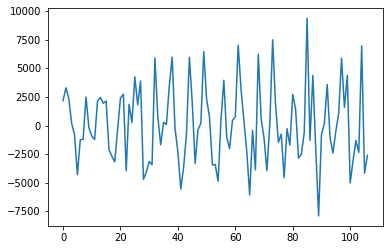

In [40]:
difference = series[1:] - series[:-1]
plt.plot(difference);

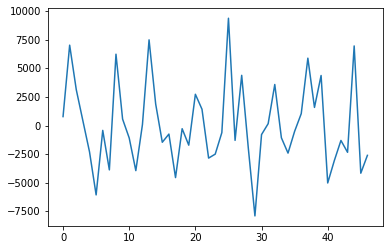

In [49]:
train_series = difference[:60]
test_series = difference[60:]
plt.plot(test_series)

In [66]:
def exponential_smoothing(alpha, s):
    history = np.append(train_series, np.zeros(len(test_series)))
    predictions = np.zeros(len(test_series))
    for i in range(len(test_series)):
        t = len(train_series) + i
        # make prediction
        if i == 0:
            predictions[i] = history[t-s]
        else:    
            predictions[i] = alpha * history[t-s] + (1 - alpha) * predictions[i-s]
        # observation
        history[t] = test_series[i]
    return predictions

In [67]:
best_a = 0
best_i = 0
best_rmse = 1e8
for a in range(21):
    for i in range(24):
        predictions = exponential_smoothing(a/20.0, i)
        rmse = np.sqrt(mean_squared_error(predictions, test_series))
        if rmse < best_rmse:
            best_rmse = rmse
            best_a = a
            best_i = i

0.65 12


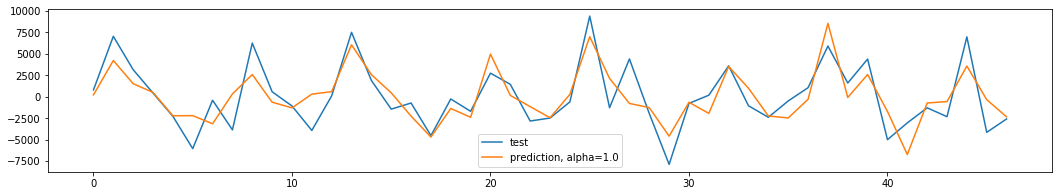

In [69]:
print(best_a/20.0, best_i)
predictions = exponential_smoothing(best_a/20.0, best_i)
rmse = np.sqrt(mean_squared_error(predictions, test_series))
plt.figure(figsize=(18,3))
plt.plot(test_series, label='test')
plt.plot(predictions, label='prediction, alpha=1.0')
plt.legend();

# Recurrent Neural Networks

A simple recurrent neural network layer is very similar to a fully-connected feed-forward neural network layer; it has a set of weights $W_x$ mapping the previous layer $x$ to each neuron of the recurrent layer, a bias term for each neuron, and an activation function. However, a recurrent neural network also has state; specifically, each neuron connects to every other neuron in the same layer with a time delay of 1. This means that a recurrent neural network layer has a second weight matrix $W_s$ of size $n$x$n$, where $n$ is the number of neurons in the recurrent layer.

One way to consider these recurrent connections is by representing the previous activation functions of the recurrent layer as a hidden state, and using that hidden state as input to the network:

<img src="img/rnn.png">

Let's try that in PyTorch, using the following scheme. We'll skip the softmax layer, as we only have 1 output:
<img src='img/linear_rnn.png'>

In [70]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [72]:
n_hidden = 16
rnn = RNN(1, n_hidden, 1)

In [73]:
hidden = rnn.init_hidden()
input = torch.from_numpy(np.array([[train_signal[-1]]])).float()
print(input)
output, hidden = rnn.forward(input, hidden)
print(output)
print(hidden)

tensor([[0.0139]])
tensor([[-0.0108]], grad_fn=<AddmmBackward>)
tensor([[-0.0007, -0.0896, -0.1994,  0.2367, -0.0653, -0.0631, -0.1413,  0.2190,
         -0.0683, -0.1740, -0.0838, -0.1383, -0.0445, -0.1491, -0.0247,  0.1782]],
       grad_fn=<AddmmBackward>)


The main difference with recurrent neural networks is that they depend on the previous state for the current state's computation. Instead of simply prediction $Y = f(x)$ as in feed-forward neural networks, recurrent networks do $Y_1 = f(x_1, f(x_0))$. Here's what an "unrolled" RNN looks like:

<img src="img/unrolled.png">

We'll first show this iterative computation, doing each step at a time. Note that PyTorch can do this computation **directly**, meaning predicting $Y = f(x)$ as long as $Y$ and $x$ are properly formatted. For now, we'll step through each sample: 

In [74]:
history = np.append(train_signal, np.zeros(len(test_signal)))
predictions = np.zeros(len(test_signal))
with torch.no_grad():
    for i in range(len(test_signal)):
        t = len(train_signal) + i
        # make prediction
        input = torch.from_numpy(np.array([[history[t-1]]])).float()
        output, hidden = rnn.forward(input, hidden)
        predictions[i] = output.detach().numpy()[0][0]
        # observation
        history[t] = test_signal[i]

0.10677338492038303


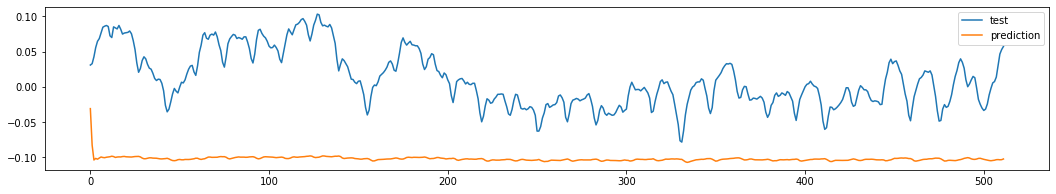

In [75]:
print(np.sqrt(mean_squared_error(predictions, test_signal)))
plt.figure(figsize=(18,3))
plt.plot(test_signal[:512], label='test')
plt.plot(predictions[:512], label='prediction')
plt.legend();

Our network doesn't do very well, but it's using random weights. In order to train it, we'll need to calcuate the gradient throughout the iterative process. This is known as **backpropogation through time**, and it relies on the computation of not just the current timestep, but all previous timesteps as well:

<img src="img/bptt.png">

In [77]:
rnn = RNN(1, n_hidden, 1)
hidden = rnn.init_hidden()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(rnn.parameters(), lr=0.001)
total_loss = 0
for t in range(1, 1001):
    optimizer.zero_grad()
    input = torch.from_numpy(np.array([[train_signal[t-1]]])).float()
    output, hidden = rnn.forward(input, hidden)
    label = torch.from_numpy(np.array([[train_signal[t]]])).float()
    loss = criterion(output, label)
    loss.backward(retain_graph=True)
    total_loss += loss.item()
    optimizer.step()
    if t % 100 == 0:
        print('%d %0.3f %0.3f %0.3f' % (t, label.item(), output.item(), total_loss))

100 0.008 0.127 3.347
200 -0.092 0.083 4.629
300 0.013 0.042 5.336
400 -0.032 0.035 5.519
500 -0.002 0.022 5.628
600 0.020 0.003 5.941
700 0.028 0.004 6.028
800 0.044 -0.003 6.259
900 -0.051 0.009 6.436
1000 0.002 0.006 6.638


In [78]:
history = np.append(train_signal, np.zeros(len(test_signal)))
predictions = np.zeros(len(test_signal))
with torch.no_grad():
    for i in range(len(test_signal)):
        t = len(train_signal) + i
        # make prediction
        input = torch.from_numpy(np.array([[history[t-1]]])).float()
        output, hidden = rnn.forward(input, hidden)
        predictions[i] = output.detach().numpy()[0][0]
        # observation
        history[t] = test_signal[i]

0.03355072220855773


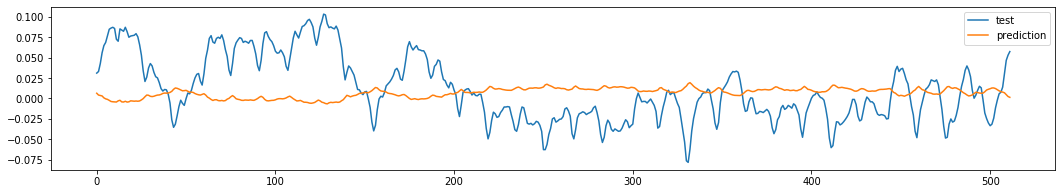

In [79]:
print(np.sqrt(mean_squared_error(predictions, test_signal)))
plt.figure(figsize=(18,3))
plt.plot(test_signal[:512], label='test')
plt.plot(predictions[:512], label='prediction')
plt.legend();

<div class="alert alert-success">
Exercise 2:
    Create a model using the PyTorch `RNN` class to train on the full training set, split up into minibatches. Test your prediction on the test set. Tweak the number of RNN layers, the size of the hidden layers, and the optimizer (RMSprop and LBFGS are common choices for RNNs). These two examples are good guides:

+ https://github.com/gabrielloye/RNN-walkthrough/blob/master/main.ipynb
+ https://github.com/pytorch/examples/blob/master/time_sequence_prediction/train.py
</div>

In [181]:
class MyRNN(nn.Module):
    def __init__(self, n_hidden):
        super(MyRNN, self).__init__()
        self.rnn_1 = nn.RNNCell(1, n_hidden)
        self.rnn_2 = nn.RNNCell(n_hidden, n_hidden)
        self.linear = nn.Linear(n_hidden, 1)

    def forward(self, input):
        outputs = []
        
        hidden_1 = torch.zeros(input.size(0), n_hidden, dtype=torch.double)
        hidden_2 = torch.zeros(input.size(0), n_hidden, dtype=torch.double)
        
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            hidden_1 = self.rnn_1(input_t, hidden_1)
            hidden_2 = self.rnn_2(hidden_1, hidden_2)
            output = self.linear(hidden_2)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [182]:
rnn = MyRNN(16)
rnn.double()

MyRNN(
  (rnn_1): RNNCell(1, 16)
  (rnn_2): RNNCell(16, 16)
  (linear): Linear(in_features=16, out_features=1, bias=True)
)

We'll create the tensors of our data. For a larger dataset, a [`DataLoader`](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) is preferable

In [183]:
input = torch.from_numpy(train_signal[:-1].reshape(1, len(train_signal)-1))
target = torch.from_numpy(train_signal[1:].reshape(1, len(train_signal)-1))

An example batch of size 8 would look like this:

In [184]:
print('X', input[:, 0:8])
print('Y', target[:, 0:8])

X tensor([[-0.0222,  0.0002,  0.0002,  0.0007,  0.0002, -0.0017, -0.0027,  0.0007]],
       dtype=torch.float64)
Y tensor([[ 0.0002,  0.0002,  0.0007,  0.0002, -0.0017, -0.0027,  0.0007,  0.0037]],
       dtype=torch.float64)


In [186]:
# build the model
rnn = MyRNN(16)
rnn.double()
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(rnn.parameters(), lr=0.00001)
batch_size = 2048
n_batch = int(np.floor(input.size(1)/batch_size))
#begin to train
for epoch in range(1):
    for batch in range(n_batch):
        batch_x = input[:, batch*batch_size:(batch+1)*batch_size]
        batch_y = target[:, batch*batch_size:(batch+1)*batch_size]
        optimizer.zero_grad()
        out = rnn(batch_x)
        loss = criterion(out, batch_y)
        if batch % 10 == 0:
            print('batch %d / %d, loss: %0.5f' % (batch, n_batch, loss.item()))
        #print(loss.item())
        loss.backward()
        optimizer.step()

batch 0 / 404, loss: 0.00419
batch 10 / 404, loss: 0.00235
batch 20 / 404, loss: 0.00341
batch 30 / 404, loss: 0.00209
batch 40 / 404, loss: 0.00295
batch 50 / 404, loss: 0.00269
batch 60 / 404, loss: 0.00394
batch 70 / 404, loss: 0.00464
batch 80 / 404, loss: 0.00577
batch 90 / 404, loss: 0.00291
batch 100 / 404, loss: 0.00302
batch 110 / 404, loss: 0.00346
batch 120 / 404, loss: 0.00580
batch 130 / 404, loss: 0.00421
batch 140 / 404, loss: 0.00711
batch 150 / 404, loss: 0.00423
batch 160 / 404, loss: 0.00456
batch 170 / 404, loss: 0.00514
batch 180 / 404, loss: 0.00426
batch 190 / 404, loss: 0.00414
batch 200 / 404, loss: 0.00697
batch 210 / 404, loss: 0.00598
batch 220 / 404, loss: 0.00335
batch 230 / 404, loss: 0.00134
batch 240 / 404, loss: 0.00115
batch 250 / 404, loss: 0.00063
batch 260 / 404, loss: 0.00042
batch 270 / 404, loss: 0.00061
batch 280 / 404, loss: 0.00066
batch 290 / 404, loss: 0.00072
batch 300 / 404, loss: 0.00058
batch 310 / 404, loss: 0.00041
batch 320 / 404, lo

In [148]:
test_input = torch.from_numpy(test_signal[:-1].reshape(1, len(test_signal)-1))
test_target = torch.from_numpy(test_signal[1:].reshape(1, len(test_signal)-1))

In [149]:
with torch.no_grad():
    pred = rnn(test_input)
    loss = criterion(pred, test_target)
    print('test loss:', loss.item())
    y = pred.detach().numpy().reshape(-1)

test loss: 0.0016346704135336081


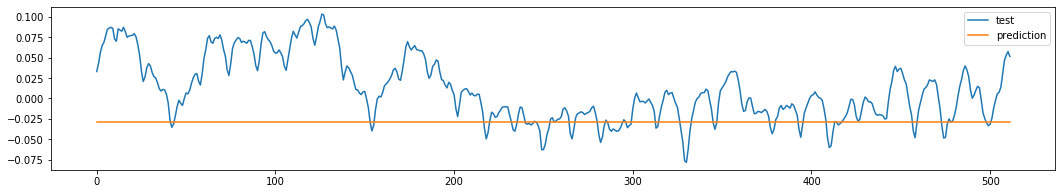

In [150]:
plt.figure(figsize=(18,3))
plt.plot(test_signal[1:513], label='test')
plt.plot(y[:512], label='prediction')
plt.legend();

# Long Short-Term Memory

A more complex recurrent neural network, which actually predates much of the current era of deep learning, is called the Long Short-Term Memory unit. This unit was designed to use different processing "gates" on two different memory storages, the hidden state like in a simple RNN, and the cell state, which is an internal memory for the LSTM.

<img src='img/lstm.png'>

While the formulation of LSTMs has changed slightly over the years, the main use currently is as follows:

$$
i_t = \sigma(W_{xi}x_t + W_{hi}h_{t-1} + W_{ci}c_{t-1}+b_i)\\
f_t = \sigma(W_{xf}x_t + W_{hf}h_{t-1} + W_{cf}c_{t-1}+b_f)\\
c_t = f_tc_{t-1}+i_t\tanh(W_{xc}x_t + W_{hc}h_{t-1} + b_c)\\
o_t = \sigma(W_{xo}x_t + W_{ho}h_{t-1} + W_{co}c_{t-1}+b_o)\\
h_t = o_t\tanh(c_t)
$$

<div class="alert alert-success">
Exercise 3

Modify your model from part exercise 2 to use the PyTorch `LSTM` or `LSTMCell` classes. Compare your test prediction error against the RNN model and against the naive baseline. Note that with LSTMs, and recurrent neural networks in general, gradients can tend to either vanish or grow very large (explode). A simple remedy to exploding gradients is using gradient clipping: `torch.nn.utils.clip_grad`.
    
Another recurrent layer type is the Gated Recurrent Unit. It was designed to solve the issue of vanishing gradients in LSTMs. [Here](https://arxiv.org/pdf/1412.3555.pdf) is an empirical study of the layer types. Try replacing your LSTM with a GRU to see if it changes your results.
</div>

If you'd like to know more about time-series prediction, [this notebook](https://github.com/marcopeix/stock-prediction/blob/master/Stock%20Prediction.ipynb) gives an example of more complex classical prediction models, notably Seasonal ARIMA.

In the next class, we'll see one of the most popular uses of LSTMs currently, in the context of [Natural Language Processing](https://arxiv.org/pdf/1810.04805.pdf). Before next class, please make sure you've installed `rasa`, `gensim`, and `nest-asyncio`.